In [2]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils.vis_utils import plot_model

import importlib
importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [3]:
tqdm.pandas()

In [4]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [5]:
import sys

In [6]:
!{sys.executable} -m list

/miniconda/bin/python: No module named list


### Get postive samples

In [7]:
drugbank = pkl.load(open('data/drugbank_embds.pkl', 'rb'))

In [8]:
drugbank

,drug_cas,drug_id,drug_name,target_actions,target_amino,target_gene,target_id,target_name,target_organism,pubchem_id,pubchem_name,target_gene_fingerprint,drug_fingerprint
31,128270-60-0,DB00006,Bivalirudin,[inhibitor],>lcl|BSEQ0016004|Prothrombin\nMAHVRGLQLPGCLALA...,>lcl|BSEQ0016005|Prothrombin (F2)\nATGGCGCACGT...,BE0000048,Prothrombin,Human,16129704,Bivalirudin,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.10044218 0.18559723 -0.12865402 -0.0650997 ...
53,65807-02-5,DB00014,Goserelin,[agonist],>lcl|BSEQ0036957|Lutropin-choriogonadotropic h...,>lcl|BSEQ0010174|Lutropin-choriogonadotropic h...,BE0000134,Lutropin-choriogonadotropic hormone receptor,Human,5311128,goserelin,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.1331214 0.2391842 -0.14361311 -0.14107014 0...
54,65807-02-5,DB00014,Goserelin,[agonist],>lcl|BSEQ0000405|Gonadotropin-releasing hormon...,>lcl|BSEQ0018926|Gonadotropin-releasing hormon...,BE0000203,Gonadotropin-releasing hormone receptor,Human,5311128,goserelin,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.1331214 0.2391842 -0.14361311 -0.14107014 0...
131,16679-58-6,DB00035,Desmopressin,[agonist],>lcl|BSEQ0000583|Vasopressin V2 receptor\nMLMA...,>lcl|BSEQ0010065|Vasopressin V2 receptor (AVPR...,BE0000293,Vasopressin V2 receptor,Human,16051933,DESMOPRESSIN,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.051722348 0.24374117 -0.16236018 -0.1723347...
132,16679-58-6,DB00035,Desmopressin,NaN,>lcl|BSEQ0009979|Vasopressin V1a receptor\nMRL...,>lcl|BSEQ0009980|Vasopressin V1a receptor (AVP...,BE0000165,Vasopressin V1a receptor,Human,16051933,DESMOPRESSIN,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.051722348 0.24374117 -0.16236018 -0.1723347...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,197922-42-2,DB08900,Teduglutide,[agonist],>lcl|BSEQ0011545|Glucagon-like peptide 2 recep...,>lcl|BSEQ0011546|Glucagon-like peptide 2 recep...,BE0002134,Glucagon-like peptide 2 receptor,Human,16139605,Teduglutide,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.15734409 0.22184908 -0.10869281 -0.08885931...
440,782500-75-8,DB09043,Albiglutide,[agonist],>lcl|BSEQ0010605|Glucagon-like peptide 1 recep...,>lcl|BSEQ0010606|Glucagon-like peptide 1 recep...,BE0000857,Glucagon-like peptide 1 receptor,Human,122173812,Albiglutide,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.15686676 0.2130656 -0.10459428 -0.094190985...
457,8063-17-0,DB09363,Rauwolfia serpentina root,[inhibitor],>lcl|BSEQ0000236|Synaptic vesicular amine tran...,>lcl|BSEQ0009946|Synaptic vesicular amine tran...,BE0000118,Synaptic vesicular amine transporter,Human,441975,Ajmalicine,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.055649024 0.22807583 -0.18862249 -0.1470914...
460,844439-96-9,DB09564,Insulin Degludec,[ligand],>lcl|BSEQ0036940|Insulin receptor\nMATGGRRGAAA...,>lcl|BSEQ0020443|Insulin receptor (INSR)\nATGG...,BE0000033,Insulin receptor,Human,118984462,Insulin degludec,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.077604994 0.26912978 -0.12892634 -0.1319705...


In [9]:
with open('data/Corona_Gene_Embeddings.pkl', 'rb') as f:
    corona_targets_df = pkl.load(f)

In [10]:
corona_target_ids = corona_targets_df['Target_DB_ID'].tolist()

In [11]:
to_drop_rows = []

for index, row in drugbank.iterrows():
    if row['target_id'] not in corona_target_ids:
        to_drop_rows.append(index)
        
drugbank = drugbank.drop(to_drop_rows)

In [12]:
drugbank['target_gene_code'] = drugbank['target_gene'].apply(lambda x: ''.join(list(x.split('\n')[1:])))
#drugbank['target_amino_code'] = drugbank['target_amino'].apply(lambda x: ''.join(list(x.split('\n')[1:])))

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
with open ('data/chem_cid_SMILE_fngr_vector_fngr.pickle', 'rb') as f:
    smiles_df = pkl.load(f)
    
smiles_df['cid'] = smiles_df['cid'].astype(int)
drugbank = pd.merge(smiles_df, drugbank, right_on = 'pubchem_id', left_on = 'cid', how = 'right')

In [14]:
drugbank = drugbank[['drug_id', 'target_id', 'fingerprint', 'target_gene_code']]
drugbank = drugbank[~ drugbank['fingerprint'].isna()]
drugbank = drugbank.rename(columns = {'fingerprint': 'drug_fingerprint_code', 'target_id': 'gene_id'})

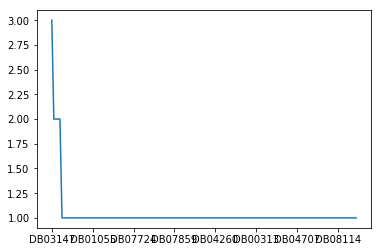

In [15]:
drugbank['drug_id'].value_counts().plot()

## NOTE: Why does NAD Bind to so many molecules?

In [16]:
drugbank[drugbank['drug_id'] == 'DB00157']

,drug_id,gene_id,drug_fingerprint_code,target_gene_code
89,DB00157,BE0000305,2968968094 4140259565 3218693969 2070178920 32...,ATGGCGGCTGCCGCACAATCCCGGGTTGTCCGGGTCCTGTCAATGT...
90,DB00157,BE0000252,2968968094 4140259565 3218693969 2070178920 32...,ATGCTCCTGGCTGTTTTGTACTGCCTGCTGTGGAGTTTCCAGACCT...


### Get DrugID -> Fingerprint mapping from positive samples

In [17]:
drug_map = drugbank[['drug_id', 'drug_fingerprint_code']].drop_duplicates('drug_id').set_index('drug_id')
target_map = drugbank[['gene_id', 'target_gene_code']].drop_duplicates('gene_id').set_index('gene_id')

In [18]:
negative_df = pd.read_csv('data/negative_samples_thrsh_12')[['node_0','node_1','shortest_path']] 
negative_df = negative_df.rename(columns = {'node_0': 'drug_id', 'node_1': 'gene_id'})
negative_df = negative_df[negative_df['drug_id'].str.contains('DB') & negative_df['gene_id'].str.contains('BE')]

In [19]:
negative_df = pd.merge(negative_df, drug_map, left_on = 'drug_id', right_index = True, how = 'left')
negative_df = pd.merge(negative_df, target_map, left_on = 'gene_id', right_index = True, how = 'left')

In [ ]:
to_drop_rows = []

for index, row in negative_df.iterrows():
    if row['gene_id'] not in corona_target_ids:
        to_drop_rows.append(index)
        
negative_df = negative_df.drop(to_drop_rows)

In [ ]:
negative_df

#### Note: Around 13% of negative samples don't match a drug id. Since the number is small, we ignore it for now

In [78]:
len(negative_df[(negative_df['target_gene_code'].isna()) |
                (negative_df['drug_fingerprint_code'].isna())])/len(negative_df)

negative_df = negative_df[(~ negative_df['target_gene_code'].isna()) &
                (~ negative_df['drug_fingerprint_code'].isna())]

In [79]:
negative_df['Y'] = 0
drugbank['Y'] = 1
drugbank = drugbank.append(negative_df) # .sample(int(len(drugbank)*1.5),replace=True)) ## NUMBER OF NEGATIVE SAMPLES TO PICK
drugbank = drugbank.drop('shortest_path', axis = 1)

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
drugbank[drugbank['target_gene_code'].str.contains('S').isna()]

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y


In [81]:
drugbank = drugbank[~ drugbank['drug_fingerprint_code'].str.contains('n')]

#### The dataset is clean and balanced

In [82]:
drugbank['Y'].value_counts()/len(drugbank)

0    0.961987
1    0.038013
Name: Y, dtype: float64

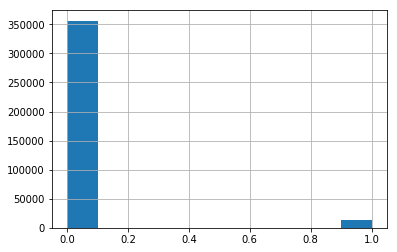

In [83]:
drugbank['Y'].hist()

#### Preprocessing fingerprints to feed to CNN

In [84]:
label_encoder = LabelEncoder()
label_encoder.fit(list(drugbank['target_gene_code'].iloc[0]))

with open('data/gene_encoder.pkl', 'wb') as f:
    pkl.dump(label_encoder, f)
    
gene_chars = set(list(drugbank['target_gene_code'].iloc[0]))

drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

In [85]:
len(drugbank['target_gene_encoded'][0])

1221

In [86]:
drugbank.head()

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,1,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,1,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,1,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,1,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,1,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."


#### Calculate length mismatches and pad

In [87]:
drugbank['target_gene_encoded_len'] = drugbank['target_gene_encoded']\
                                    .apply(lambda x: len(x))
drugbank['drug_fingerprint_encoded_len'] = drugbank['drug_fingerprint_encoded']\
                                    .apply(lambda x: len(x))

In [88]:
drugbank['mismatch'] = drugbank[['target_gene_encoded', 'drug_fingerprint_encoded']]\
                        .apply(lambda x: len(x['target_gene_encoded']) - len(x['drug_fingerprint_encoded']), axis = 1)

## Most Genes are longer than fingerprints

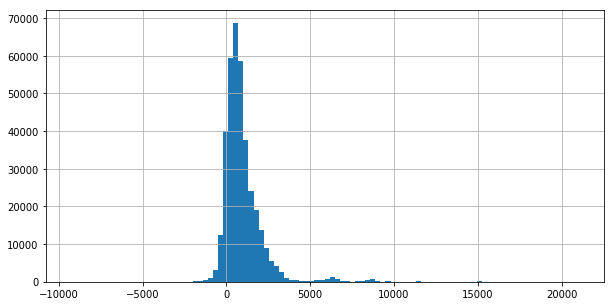

In [89]:
drugbank['mismatch'].hist(bins = 100, figsize = (10, 5))

In [90]:
print('95 percent of the mismatches are of the range %f to %f' % (max(drugbank['mismatch'].value_counts()) - np.std(drugbank['mismatch'].value_counts()),
                                                           max(drugbank['mismatch'].value_counts()) + np.std(drugbank['mismatch'].value_counts())))

95 percent of the mismatches are of the range 228.361840 to 357.638160


In [91]:
max_target_gene_encoded_len = max(drugbank['target_gene_encoded_len'])
max_drug_fingerprint_encoded_len = max(drugbank['drug_fingerprint_encoded_len'])

In [92]:
drugbank['target_gene_encoded_mismatch'] = max_target_gene_encoded_len - drugbank['target_gene_encoded_len']

In [93]:
drugbank['drug_fingerprint_encoded_mismatch'] = max_drug_fingerprint_encoded_len - drugbank['drug_fingerprint_encoded_len'] 

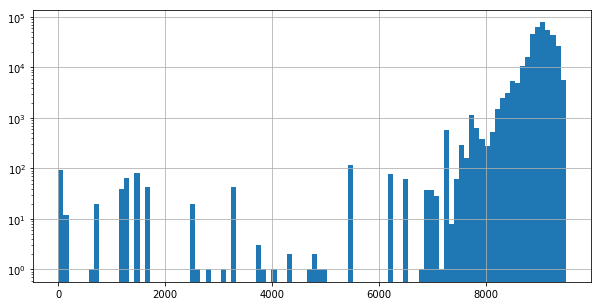

In [94]:
drugbank['drug_fingerprint_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

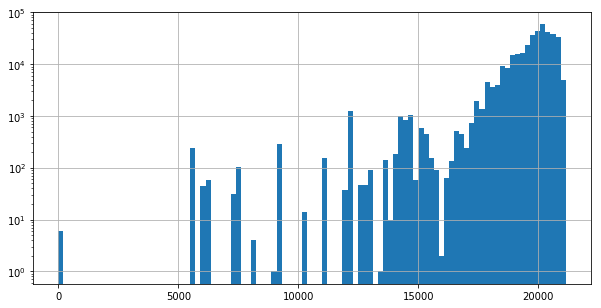

In [95]:
drugbank['target_gene_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

#### There appears to be quite large intracolumn mismatches in length. Unsure how to deal with it now. Current strategy is to pad the inputs and model it

In [96]:
max_target_gene_encoded_len

21222

In [97]:
drugbank['target_gene_encoded'][0].shape

(1221,)

In [98]:
drugbank['target_gene_encoded_padded'] = drugbank[['target_gene_encoded','target_gene_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['target_gene_encoded_mismatch']/2))] +   
                                                        list(x['target_gene_encoded']) +
                                                        ['-1' for i in range (int(x['target_gene_encoded_mismatch']/2))]
                                                        , axis = 1)
drugbank['target_gene_encoded_padded'] = drugbank['target_gene_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_target_gene_encoded_len else x)

In [99]:
drugbank['drug_fingerprint_encoded_padded'] = drugbank[['drug_fingerprint_encoded','drug_fingerprint_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['drug_fingerprint_encoded_mismatch']/2))] +   
                                                        list(x['drug_fingerprint_encoded']) +
                                                        ['-1' for i in range (int(x['drug_fingerprint_encoded_mismatch']/2))]
                                                        , axis = 1)

drugbank['drug_fingerprint_encoded_padded'] = drugbank['drug_fingerprint_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_drug_fingerprint_encoded_len else x)

In [2]:
drugbank

NameError: name 'drugbank' is not defined

In [111]:
drugbank_30K = drugbank.head(30000)

In [112]:
drugbank_30K.to_pickle('data/all_postive_negative_samples_dump.pkl')

In [43]:
drugbank.sample(frac=1).reset_index(drop=True).to_csv('data/intermediate/covid_gene_only_interactions_preprocessed.csv', index = False)

In [44]:
del smiles_df, negative_df

In [45]:
del drugbank

## ROC for Corona Genes

In [12]:
drugbank = pd.read_pickle('data/all_postive_negative_samples_dump.pkl')

In [51]:
drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv',iterator = False, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


In [13]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,1,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",1221,547,674,20001,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,1,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2466,547,1919,18756,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,1,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2160,547,1613,19062,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,1,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2058,547,1511,19164,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,1,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ...",2196,547,1649,19026,8954,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88812,DB04576,BE0004634,2246728737 3657471097 2092489639 2021812431 29...,ATGGCTACTTCAAAGTTGCCCGTGGTGCCTGGGGAGGAGGAAAACA...,0,"[0, 3, 2, 2, 1, 3, 0, 1, 3, 3, 1, 0, 0, 0, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",1392,508,884,19830,8993,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
88813,DB04576,BE0001790,2246728737 3657471097 2092489639 2021812431 29...,ATGGAAATTAATGTGAGTAAATTAAGAACAGATTTGCCTCAAGTCG...,0,"[0, 3, 2, 2, 0, 0, 0, 3, 3, 0, 0, 3, 2, 3, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",957,508,449,20265,8993,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
88814,DB04576,BE0000597,2246728737 3657471097 2092489639 2021812431 29...,ATGAAGACGTTATCTCCCGCTGTGATTACTTTACTCTGGCGTCAGG...,0,"[0, 3, 2, 0, 0, 2, 0, 1, 2, 3, 3, 0, 3, 1, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",1362,508,854,19860,8993,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
88825,DB04576,BE0001417,2246728737 3657471097 2092489639 2021812431 29...,ATGCAAACGGAACACGTCATTTTATTGAATGCACAGGGAGTTCCCA...,0,"[0, 3, 2, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 1, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",549,508,41,20673,8993,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [14]:
drugbank = drugbank_30K

NameError: name 'drugbank_30K' is not defined

In [114]:
to_drop_rows = []

for index, row in drugbank.iterrows():
    if row['gene_id'] not in corona_target_ids:
        to_drop_rows.append(index)
        
drugbank = drugbank.drop(to_drop_rows)

KeyboardInterrupt: 

In [15]:
X_0 = np.array(drugbank['target_gene_encoded_padded'].tolist())
X_1 = np.array(drugbank['drug_fingerprint_encoded_padded'].tolist())
Y   = np.array(drugbank['Y'].tolist())

In [16]:
X_0 = np.vectorize(lambda x: int(x))(X_0)
X_1 = np.vectorize(lambda x: int(x))(X_1)
Y = np.vectorize(lambda x: int(x))(Y)

In [17]:
X_0_dim_fixed = np.zeros((len(X_0),len(X_0[0])))
X_1_dim_fixed = np.zeros((len(X_1),len(X_1[0])))
Y_dim_fixed = np.zeros((len(Y),1))

In [18]:
for i in range(len(X_0)):
    for j in range(len(X_0[0])):
        X_0_dim_fixed[i,j] = X_0[i][j]

In [19]:
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_1_dim_fixed[i,j] = X_1[i][j]

In [20]:
X_0_dim_fixed.shape, X_1_dim_fixed.shape, Y_dim_fixed.shape

((30000, 21222), (30000, 9501), (30000, 1))

In [21]:
X_validate = np.zeros((X_0_dim_fixed.shape[0], X_0_dim_fixed.shape[1] + X_1_dim_fixed.shape[1]))

In [22]:
for i in range(len(X_0_dim_fixed)):
    X_validate[i,:] = np.hstack((X_0_dim_fixed[i,:], X_1_dim_fixed[i,:])) + 1

In [23]:
target_length = 30723
X_validate = X_validate[:, :target_length]

In [24]:
from tensorflow import keras

use_model = keras.models.load_model('models/CNN_GPU_VGG_80p.model')

In [25]:
Y_validate = use_model.predict(X_validate[..., np.newaxis])

In [26]:
Y_true = list(Y)

In [32]:
Y_true.count(1),Y_true.count(0)

(14074, 15926)

In [31]:
Y_predicted = []

for i in range(Y_validate.shape[0]):
    Y_predicted.append(Y_validate[i][0])

Text(0,0.5,'Number of Pairs')

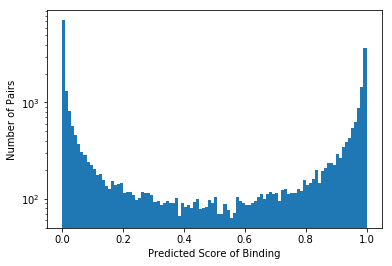

In [28]:
plt.hist(Y_validate, bins = 100, log = True)
plt.xlabel('Predicted Score of Binding')
plt.ylabel('Number of Pairs')

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, threshold = roc_curve(Y_true, Y_predicted)
print('roc_auc_score: ', roc_auc_score(Y_true, Y_predicted))

roc_auc_score:  0.892484076337072


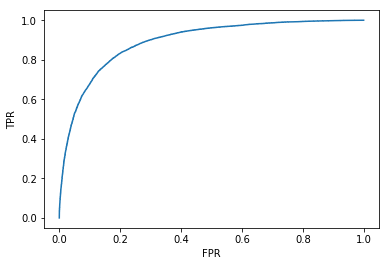

In [30]:
import matplotlib.pyplot as plt

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# ROC for All Genes

In [57]:
drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv',iterator = False, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})


In [58]:
X_0 = np.array(drugbank['target_gene_encoded_padded'].tolist())
X_1 = np.array(drugbank['drug_fingerprint_encoded_padded'].tolist())
Y   = np.array(drugbank['Y'].tolist())

In [59]:
list(Y).count(0),list(Y).count(1),len(Y)

(21106, 14074, 35180)

In [33]:
X_0 = np.vectorize(lambda x: int(x))(X_0)
X_1 = np.vectorize(lambda x: int(x))(X_1)
Y = np.vectorize(lambda x: int(x))(Y)

In [34]:
X_0_dim_fixed = np.zeros((len(X_0),len(X_0[0])))
X_1_dim_fixed = np.zeros((len(X_1),len(X_1[0])))
Y_dim_fixed = np.zeros((len(Y),1))

In [35]:
for i in range(len(X_0)):
    for j in range(len(X_0[0])):
        X_0_dim_fixed[i,j] = X_0[i][j]

In [36]:
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_1_dim_fixed[i,j] = X_1[i][j]

In [37]:
X_validate = np.zeros((X_0_dim_fixed.shape[0], X_0_dim_fixed.shape[1] + X_1_dim_fixed.shape[1]))

In [38]:
for i in range(len(X_0_dim_fixed)):
    X_validate[i,:] = np.hstack((X_0_dim_fixed[i,:], X_1_dim_fixed[i,:])) + 1

In [39]:
target_length = 30723
X_validate = X_validate[:, :target_length]

In [40]:
Y_validate = use_model.predict(X_validate[..., np.newaxis])

In [41]:
Y_true = list(Y)

In [42]:
Y_predicted = []

for i in range(Y_validate.shape[0]):
    Y_predicted.append(Y_validate[i][0])

Text(0,0.5,'Number of Pairs')

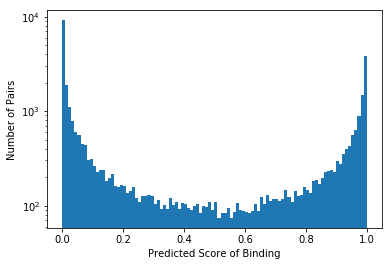

In [43]:
plt.hist(Y_validate, bins = 100, log = True)
plt.xlabel('Predicted Score of Binding')
plt.ylabel('Number of Pairs')

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, threshold = roc_curve(Y_true, Y_predicted)
print('roc_auc_score: ', roc_auc_score(Y_true, Y_predicted))

roc_auc_score:  0.8985129699373946


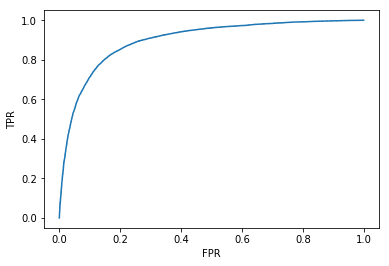

In [45]:
import matplotlib.pyplot as plt

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Naturally occuring drugs

In [46]:
all_drug_id_list = drugbank['drug_id'].tolist()

In [47]:
all_drug_id_list.count('DB07810')

2

In [48]:
all_drug_id_list.count('DB04216')

11

In [49]:
all_drug_id_list.count('DB03467')

11